In [1]:
import numpy as np
import torch
import sklearn.metrics as metrics
from sklearn.utils import shuffle
import pickle
import matplotlib.pyplot as plt
import matplotlib
from models import CNN, CNN_LSTM, CNN_LSTM2

from captum.attr import DeepLiftShap

### Path to model

In [2]:
MODEL = CNN
PATH = '../runs/CNN_08-12_16:06/'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


model = MODEL()
model.load_state_dict(torch.load(f'{PATH}/state_dict.pth',map_location=torch.device('cpu')))
model.to(device)
model.eval()

with open(f'{PATH}/hyperparams.log','r') as file:
    log = file.read()
print(log)

Model: CNN(
  (conv1): Conv1d(4, 64, kernel_size=(21,), stride=(1,), padding=(10,))
  (conv2): Conv1d(64, 128, kernel_size=(11,), stride=(1,), padding=(5,))
  (conv3): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.2, inplace=False)
  (drop2): Dropout(p=0.3, inplace=False)
  (dense1): Linear(in_features=5120, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=73, bias=True)
)
                     LAYER   PARAMS
0             conv1.weight     5376
1               conv1.bias       64
2             conv2.weight    90112
3               conv2.bias      128
4             conv3.weight   163840
5               conv3.bias      256
6            dense1.weight  1310720
7              dense1.bias      256
8            dense2.weight    18688
9              dense2.bias       73
10  Total Trainable Params  1589513
epochs:30	batch_size:128	learning_rate:

### Load dataset

In [3]:
#LOAD TRAIN/VAL DATA
np_data = np.load('../dataset/train_data.npy')
np_targets = np.load('../dataset/train_targets.npy')

#data into tensors
data = torch.Tensor(np_data).transpose(1,2)   #input shape (batch, in_channels=4, in_sequence=500)
targets = torch.Tensor(np_targets)

dataset = torch.utils.data.TensorDataset(data, targets)
seed = torch.Generator().manual_seed(17912)
train_size = int(0.8889 * len(dataset))
train, val = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size], generator=seed)

#LOAD TEST DATA
np_test_data = np.load('../dataset/test_set/test_data.npy')
np_test_targets = np.load('../dataset/test_set/test_targets.npy')
test_data = torch.Tensor(np_test_data).transpose(1,2)
test_targets = torch.Tensor(np_test_targets)

test_dataset = torch.utils.data.TensorDataset(test_data,test_targets)

NUM_CLASSES = len(targets.T)

### Checking for class imbalance in training/validation data

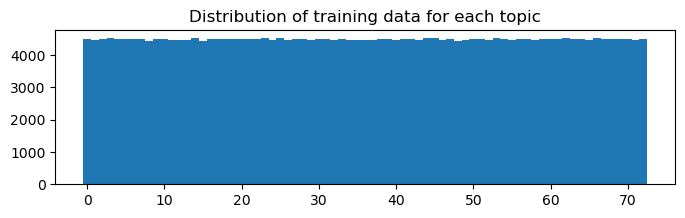

In [4]:
topics_distribution = np.array([np.sum(np_targets[:,i]) for i in range(len(targets.T))])
fig = plt.figure(figsize=(8,2))
plt.bar(range(len(targets[0])),topics_distribution,width=1)
plt.title("Distribution of training data for each topic")
fig.show()

### Model performance 
#### Load predictions and labels dictionary

In [5]:
prediction_dict = pickle.load(open(f'{PATH}/predictions.pickle','rb'))

#### Run predictions for test set

In [6]:
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = 128, shuffle=False, num_workers=1)

tpredictions = np.zeros((0,len(targets.T)))
tlabels = np.zeros((0,len(targets.T)))
with torch.no_grad():
    for tdata in testloader:
        tinputs, ttargets = tdata[0].to(device), tdata[1]
        if model.name=='CNN_LSTM2':
            tinputs_rc = np.array(tinputs)[:,::-1,::-1]
            tinputs_rc = torch.Tensor(tinputs_rc.copy()).to(device)
            toutputs = model(tinputs, tinputs_rc)
        else:
            toutputs = model(tinputs)

        tpredictions = np.append(tpredictions, toutputs.detach().cpu(),axis=0)
        tlabels = np.append(tlabels, ttargets.detach(),axis=0)

prediction_dict["test"]={}
prediction_dict["test"]["prediction"] = tpredictions
prediction_dict["test"]["labels"] = tlabels

### average auROC and auPR per topic

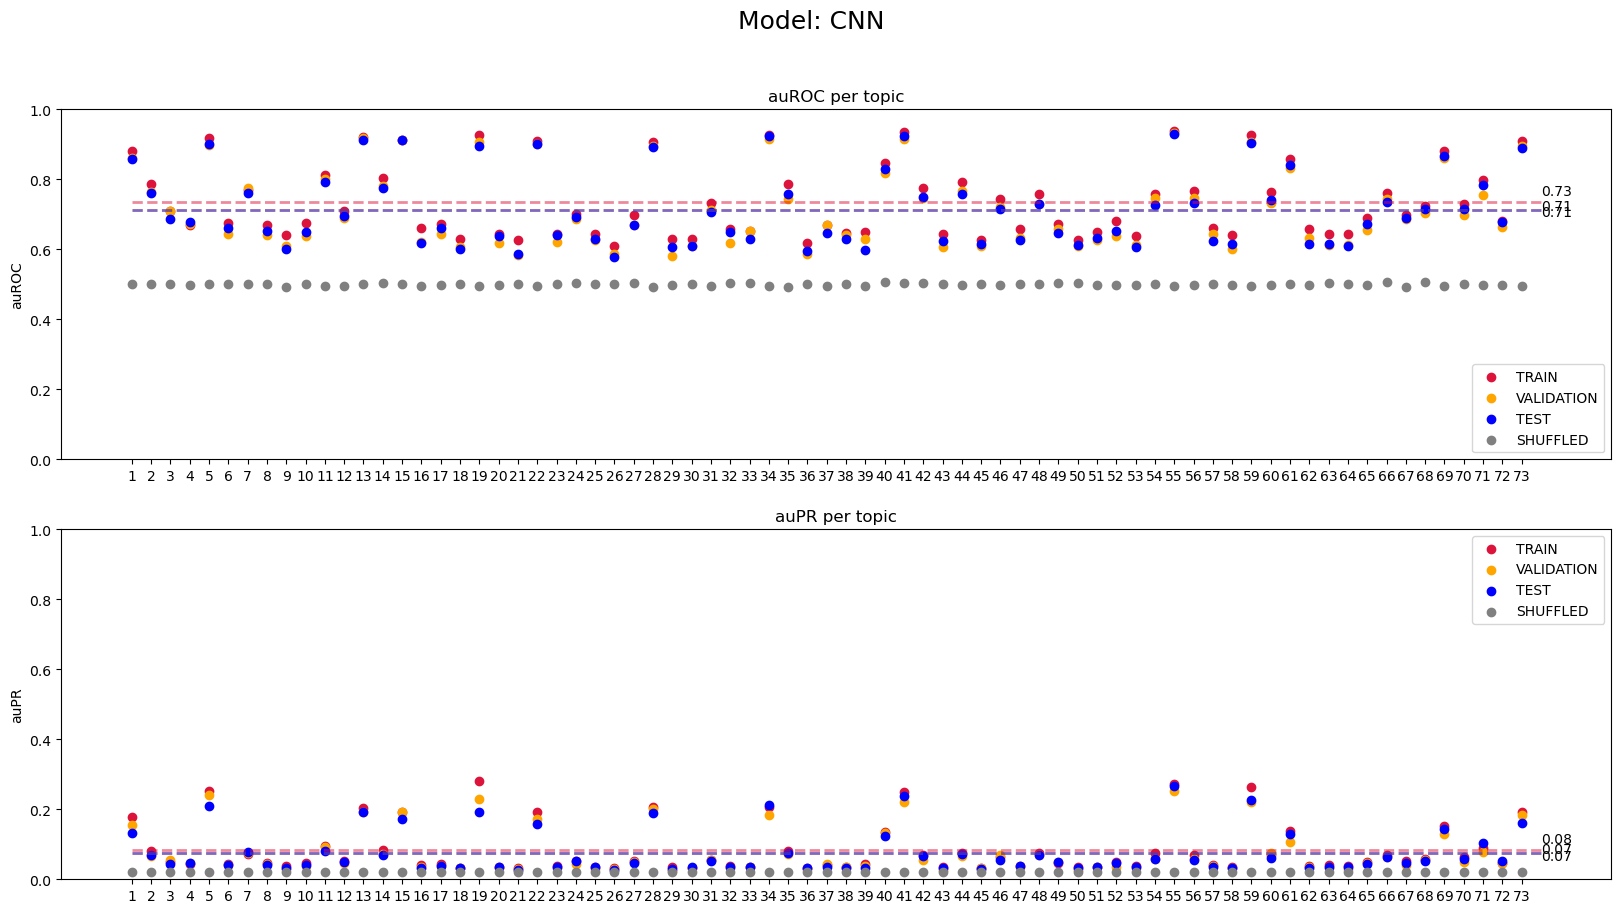

In [7]:
selected_topics = np.arange(NUM_CLASSES)

prediction_dict["shuffled"] = {}
prediction_dict["shuffled"]["prediction"] = np.array(prediction_dict["train"]["prediction"]).copy()
prediction_dict["shuffled"]["labels"] = shuffle(prediction_dict["train"]["labels"].copy())

for key in prediction_dict.keys():
    prediction_dict[key]["auROC"] = np.array([metrics.roc_auc_score(prediction_dict[key]["labels"].T[i],
                                        prediction_dict[key]["prediction"].T[i]) for i in range(NUM_CLASSES)])
    prediction_dict[key]["auPR"] = np.array([metrics.average_precision_score(prediction_dict[key]["labels"].T[i],
                                        prediction_dict[key]["prediction"].T[i]) for i in range(NUM_CLASSES)])

    prediction_dict[key]["mean_auROC"] = np.average(prediction_dict[key]["auROC"])
    prediction_dict[key]["mean_auPR"] = np.average(prediction_dict[key]["auPR"])


fig,(ax1,ax2) = plt.subplots(2,1,figsize=(20, 10))
lw=2
fig.suptitle(f"Model: {model.name}", fontsize=18)
for ax,metric in (ax1,"auROC"),(ax2,"auPR"):

    ax.set_title(f"{metric} per topic")
    ax.set_ylabel(f"{metric}")

    #TRAIN
    ax.scatter(list(selected_topics), prediction_dict["train"][metric][selected_topics], color='crimson',\
               label='TRAIN')

    #plot and label mean vals
    ax.plot([0,len(selected_topics)], [prediction_dict["train"][f"mean_{metric}"]]*2, color="crimson", lw=lw,\
            linestyle="--", alpha=0.5)
    ax.text(len(selected_topics), prediction_dict["train"][f"mean_{metric}"]+0.02,
            s=np.round(prediction_dict["train"][f"mean_{metric}"],2))
    
    #VAL
    ax.scatter(list(selected_topics), prediction_dict["val"][metric][selected_topics], color='orange',\
               label='VALIDATION')

    #plot and label mean vals
    ax.plot([0,len(selected_topics)], [prediction_dict["val"][f"mean_{metric}"]]*2, color="orange", lw=lw,\
            linestyle="--", alpha=0.5)
    ax.text(len(selected_topics),prediction_dict["val"][f"mean_{metric}"],
                s=np.round(prediction_dict["val"][f"mean_{metric}"],2))
    
    #TEST
    ax.scatter(list(selected_topics), prediction_dict["test"][metric][selected_topics], color='blue',\
               label='TEST')
    
    #plot and label mean vals
    ax.plot([0,len(selected_topics)], [prediction_dict["test"][f"mean_{metric}"]]*2, color="blue", lw=lw,\
            linestyle="--", alpha=0.5)
    ax.text(len(selected_topics),prediction_dict["test"][f"mean_{metric}"]-0.02,
                s=np.round(prediction_dict["test"][f"mean_{metric}"],2))

    #SHUFFLED
    ax.scatter(list(selected_topics), prediction_dict["shuffled"][metric][selected_topics], color='gray',\
               label='SHUFFLED')
    ax.set_ylim([0, 1])
    ax.set_xticks(selected_topics,selected_topics+1)

ax1.legend(loc='lower right')
ax2.legend(loc='upper right')

fig.show()

In [8]:
print(f'Average training auROC: {np.average(prediction_dict["train"]["mean_auROC"])}\n'+
      f'Average validation auROC: {np.average(prediction_dict["val"]["mean_auROC"])}\n'+
      f'Average test auROC: {np.average(prediction_dict["test"]["mean_auROC"])}\n'+
      f'Average training auPR: {np.average(prediction_dict["train"]["mean_auPR"])}\n'+
      f'Average validation auPR: {np.average(prediction_dict["val"]["mean_auPR"])}\n'+
      f'Average test auPR: {np.average(prediction_dict["test"]["mean_auPR"])}')

Average training auROC: 0.734066005247952
Average validation auROC: 0.712080170199843
Average test auROC: 0.713153407421188
Average training auPR: 0.08261252527008184
Average validation auPR: 0.07446120254422534
Average test auPR: 0.07403278040633553


#### ROC & PR curves

In [9]:
fpr,tpr,precision,recall,roc_thresholds = {},{},{},{},{}
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], roc_thresholds[i] = metrics.roc_curve(prediction_dict["val"]["labels"][:, i], prediction_dict["val"]["prediction"][:, i])
    precision[i], recall[i], _ = metrics.precision_recall_curve(prediction_dict["val"]["labels"][:, i], prediction_dict["val"]["prediction"][:, i])

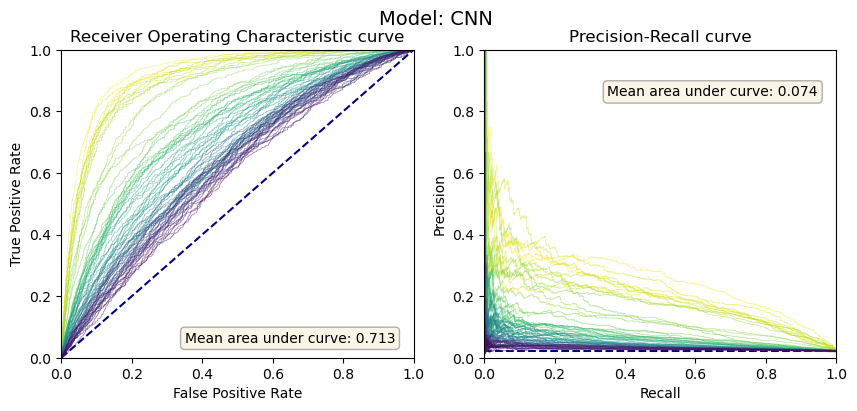

In [10]:
sorted_indices_auROC = np.flip(np.argsort(prediction_dict["test"]["auROC"]))
sorted_indices_auPR = np.flip(np.argsort(prediction_dict["test"]["auPR"]))

colors = plt.cm.viridis(np.linspace(1, 0, NUM_CLASSES))

#The "baseline curve" in a PR curve plot is a horizontal line with height equal to the number of positive examples
# over the total number of training data, ie. the proportion of positive examples in our data
PR_baseline = np.sum(prediction_dict["train"]["labels"][:,0])/len(prediction_dict["train"]["labels"])

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
fig.suptitle(f"Model: {model.name}",fontsize=14)
lw = 1.5

#ROC
ax1.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
ax1.text(0.35,0.05,f'Mean area under curve: {round(prediction_dict["test"]["mean_auROC"],3)}',\
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
ax1.set_ylim([0.0, 1.0])
ax1.set_xlim([0.0, 1.0])
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.title.set_text(f"Receiver Operating Characteristic curve")

for i, topic in enumerate(sorted_indices_auROC):
    ax1.plot(fpr[topic],tpr[topic],color=colors[i],alpha=0.5,lw=0.5)

#PR
ax2.plot([0, 1], [PR_baseline, PR_baseline], color="navy", lw=lw, linestyle="--")
ax2.text(0.35,0.85,f'Mean area under curve: {round(prediction_dict["test"]["mean_auPR"],3)}',\
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
ax2.set_ylim([0.0, 1.0])
ax2.set_xlim([0.0, 1.0])
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.title.set_text(f"Precision-Recall curve")

for i, topic in enumerate(sorted_indices_auPR):
    ax2.plot(recall[topic],precision[topic],color=colors[i],alpha=0.5,lw=0.5)

fig.show()

#### Confusion Matrix

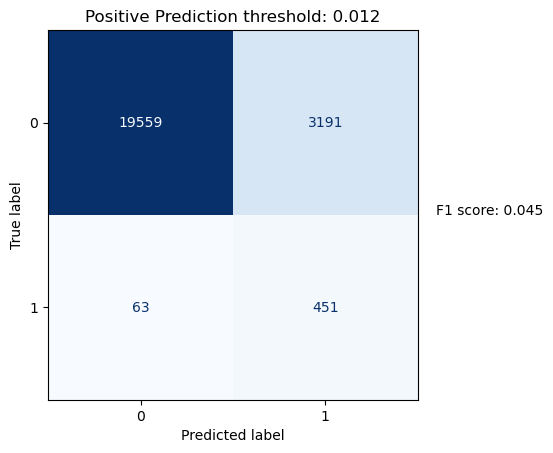

In [11]:
i=sorted_indices_auROC[0]
d=(0-fpr[i])**2+(1-tpr[i])**2
threshold_index = np.where(d==min(d))[0][0]
optimal_ROC_threshold=roc_thresholds[i][threshold_index]
F1_score = (2*precision[i][threshold_index]*recall[i][threshold_index])/(precision[i][threshold_index]+recall[i][threshold_index])

conf_mat = metrics.multilabel_confusion_matrix(prediction_dict["val"]["labels"],prediction_dict["val"]["prediction"]>=optimal_ROC_threshold)
disp = metrics.ConfusionMatrixDisplay(conf_mat[i])
disp.plot(cmap='Blues',values_format='d')
disp.ax_.set_title(f'Positive Prediction threshold: {round(optimal_ROC_threshold,3)}')
disp.im_.colorbar.remove()
disp.ax_.text(1.6,0.5,f'F1 score: {round(F1_score,3)}')
disp.figure_.show()

### Get prediction for a single input sequence

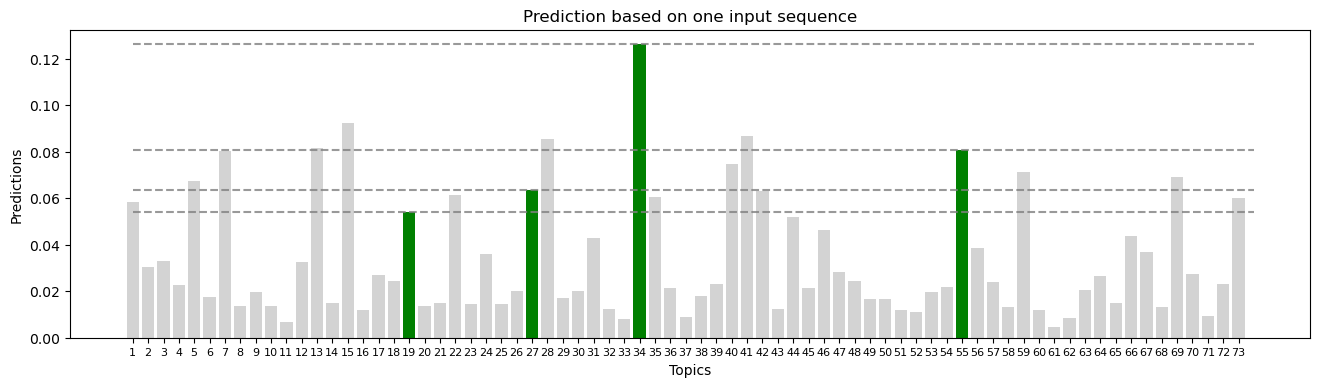

In [12]:
sel_sequence=16383

predictions = prediction_dict["test"]["prediction"][sel_sequence]
label = np.nonzero(prediction_dict["test"]["labels"][sel_sequence]*np.ones(73))[0]

colour_array = np.array(["lightgray"]*NUM_CLASSES)
colour_array[label] = "green"

fig = plt.figure(figsize=(16,4))
plt.bar(range(NUM_CLASSES),predictions,color=colour_array)

for i in label:
    plt.plot([0,NUM_CLASSES],[predictions[i]]*2,color='gray',linestyle='--',alpha=0.8)

plt.title("Prediction based on one input sequence")
plt.ylabel("Predictions")
plt.xlabel("Topics")
plt.xticks(np.arange(NUM_CLASSES),np.arange(1,NUM_CLASSES+1),fontsize=8)
fig.show()

#### plotting functions (from https://github.com/aertslab/DeepMEL/blob/master/scoring_and_deepexplainer.ipynb)

In [13]:
def plot_a(ax, base, left_edge, height, color):
    a_polygon_coords = [
        np.array([
           [0.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.2, 0.0],
        ]),
        np.array([
           [1.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.8, 0.0],
        ]),
        np.array([
           [0.225, 0.45],
           [0.775, 0.45],
           [0.85, 0.3],
           [0.15, 0.3],
        ])
    ]
    for polygon_coords in a_polygon_coords:
        ax.add_patch(matplotlib.patches.Polygon((np.array([1,height])[None,:]*polygon_coords
                                                 + np.array([left_edge,base])[None,:]),
                                                facecolor=color, edgecolor=color))

def plot_c(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
                                            facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
                                            facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+1, base], width=1.0, height=height,
                                            facecolor='white', edgecolor='white', fill=True))

def plot_g(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
                                            facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
                                            facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+1, base], width=1.0, height=height,
                                            facecolor='white', edgecolor='white', fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.825, base+0.085*height], width=0.174, height=0.415*height,
                                            facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.625, base+0.35*height], width=0.374, height=0.15*height,
                                            facecolor=color, edgecolor=color, fill=True))

def plot_t(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.4, base],
                  width=0.2, height=height, facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge, base+0.8*height],
                  width=1.0, height=0.2*height, facecolor=color, edgecolor=color, fill=True))

default_colors = {0:'green', 1:'blue', 2:'orange', 3:'red'}
default_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_t}
def plot_weights_given_ax(ax, array,
                 height_padding_factor,
                 length_padding,
                 subticks_frequency,
                 highlight,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs):
    if len(array.shape)==3:
        array = np.squeeze(array)
    assert len(array.shape)==2, array.shape
    if (array.shape[0]==4 and array.shape[1] != 4):
        array = array.transpose(1,0)
    assert array.shape[1]==4
    max_pos_height = 0.0
    min_neg_height = 0.0
    heights_at_positions = []
    depths_at_positions = []
    for i in range(array.shape[0]):
        acgt_vals = sorted(enumerate(array[i,:]), key=lambda x: abs(x[1]))
        positive_height_so_far = 0.0
        negative_height_so_far = 0.0
        for letter in acgt_vals:
            plot_func = plot_funcs[letter[0]]
            color=colors[letter[0]]
            if letter[1] > 0:
                height_so_far = positive_height_so_far
                positive_height_so_far += letter[1]                
            elif letter[1] < 0:
                height_so_far = negative_height_so_far
                negative_height_so_far += letter[1]
            else:
                height_so_far = 0.0
            plot_func(ax=ax, base=height_so_far, left_edge=i, height=letter[1], color=color)
        max_pos_height = max(max_pos_height, positive_height_so_far)
        min_neg_height = min(min_neg_height, negative_height_so_far)
        heights_at_positions.append(positive_height_so_far)
        depths_at_positions.append(negative_height_so_far)
    for color in highlight:
        for start_pos, end_pos in highlight[color]:
            assert start_pos >= 0.0 and end_pos <= array.shape[0]
            min_depth = np.min(depths_at_positions[start_pos:end_pos])
            max_height = np.max(heights_at_positions[start_pos:end_pos])
            ax.add_patch(
                matplotlib.patches.Rectangle(xy=[start_pos,min_depth],
                    width=end_pos-start_pos,
                    height=max_height-min_depth,
                    edgecolor=color, fill=False))
            
    ax.set_xlim(-length_padding, array.shape[0]+length_padding)
    ax.xaxis.set_ticks(np.arange(0.0, array.shape[0]+1, subticks_frequency))
    height_padding = max(abs(min_neg_height)*(height_padding_factor),
                         abs(max_pos_height)*(height_padding_factor))
    ax.set_ylim(min_neg_height-height_padding, max_pos_height+height_padding)
    return ax

def plot_weights_modified(array, fig, n,n1,n2, title='', ylab='',
                              figsize=(20,2),
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency=20,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs,
                 highlight={}):
    ax = fig.add_subplot(n,n1,n2) 
    ax.set_title(title)
    ax.set_ylabel(ylab)
    y = plot_weights_given_ax(ax=ax, array=array,
        height_padding_factor=height_padding_factor,
        length_padding=length_padding,
        subticks_frequency=subticks_frequency,
        colors=colors,
        plot_funcs=plot_funcs,
        highlight=highlight)
    return fig,ax

#### additional functions

In [14]:
def get_seq(data, fasta=False):
    """returns a list of DNA sequences from a 3-D numpy array containing the one-hot encoded sequences.
    
    :param fasta: Indicates whether output should be in a faste format, with the header corresponding to the index of the input
        (default is False)
    """
    if type(data)==torch.Tensor:
        data = data.numpy().astype('int8')
        
    if len(data.shape)==2:
        data = np.array([data])
        
    if data.shape[1]==4:
        data = data.swapaxes(1,2)

    data_seq = []
    nucleotides=np.array(['N','A','C','G','T'])
    indices=np.arange(1,5)
    seq_array = nucleotides[np.dot(data, indices)]
    for i,read in enumerate(seq_array):
        seq = ''.join(read)
        
        format=''
        if fasta==True:format=f"\n>{i}\n"
        data_seq.append(format+seq)
        
    if len(data_seq)==1:data_seq=data_seq[0]

    return data_seq

def seq_to_one_hot(data):
    """returns one-hot encoded sequence
    
    :param data: input sequence
    :type data:str,list,tuple
    """
    result=[]
    if type(data)==str: data = [data]
    
    for sequence in data:
        sequence.upper()
        letters_pos=np.array(['A','C','G','T'])
        unpacked_seq=np.array([*sequence])
        one_hot_array=np.array([np.compare_chararrays(letters_pos,letter,cmp='==',rstrip=True)\
                                for letter in unpacked_seq],dtype='int8')
        result.append(one_hot_array)
    return np.array(result)

### Model interpretation

Interpretation with captum's [DeepLiftShap](https://captum.ai/api/deep_lift_shap.html)

Note that the explanation model:

        1. Assumes that input features are independent of one another

        2. Is linear, meaning that the explanations are modeled through

            the additive composition of feature effects.




#### 100 random sequences as baseline

In [15]:
#100 random sequences from test set chosen as baseline
indices = np.random.randint(0,len(test_data),100)
random_sample = torch.Tensor(np_test_data[indices].copy()).transpose(1,2).to(device)

#### Load sequence

In [23]:
sel_sequence = np_test_data[1000:1001]
sequence_name = 'Seq'

In [24]:
input_tensor = torch.Tensor(sel_sequence).transpose(1,2).to(device)
input_tensor_rc = torch.Tensor(sel_sequence[:,::-1,::-1].copy()).transpose(1,2).to(device)

if model.name == 'CNN_LSTM2':
    pred=model(input_tensor,input_tensor_rc)
    target = torch.argmax(pred).tolist()
else:
    pred=model(input_tensor)
    target = torch.argmax(pred).tolist()

top_ten_topics = torch.argsort(pred,descending=True).cpu().numpy().flatten()[:10]+1
print(f'Highest scoring topics: {top_ten_topics}')

Highest scoring topics: [68 60 61 11 14 65 71 39 51  2]


In [25]:
torch.backends.cudnn.enabled=False # CuDNN with RNN / LSTM doesn't support gradient computation in eval mode that's why we need to disable cudnn for RNN in eval mode.

sv = DeepLiftShap(model, multiply_by_inputs=False)

shap_values = sv.attribute(inputs=input_tensor, baselines=random_sample,
                           target=(target,)).cpu()

shap_values_rc = sv.attribute(inputs=input_tensor_rc, baselines=random_sample,
                           target=(target,)).cpu()

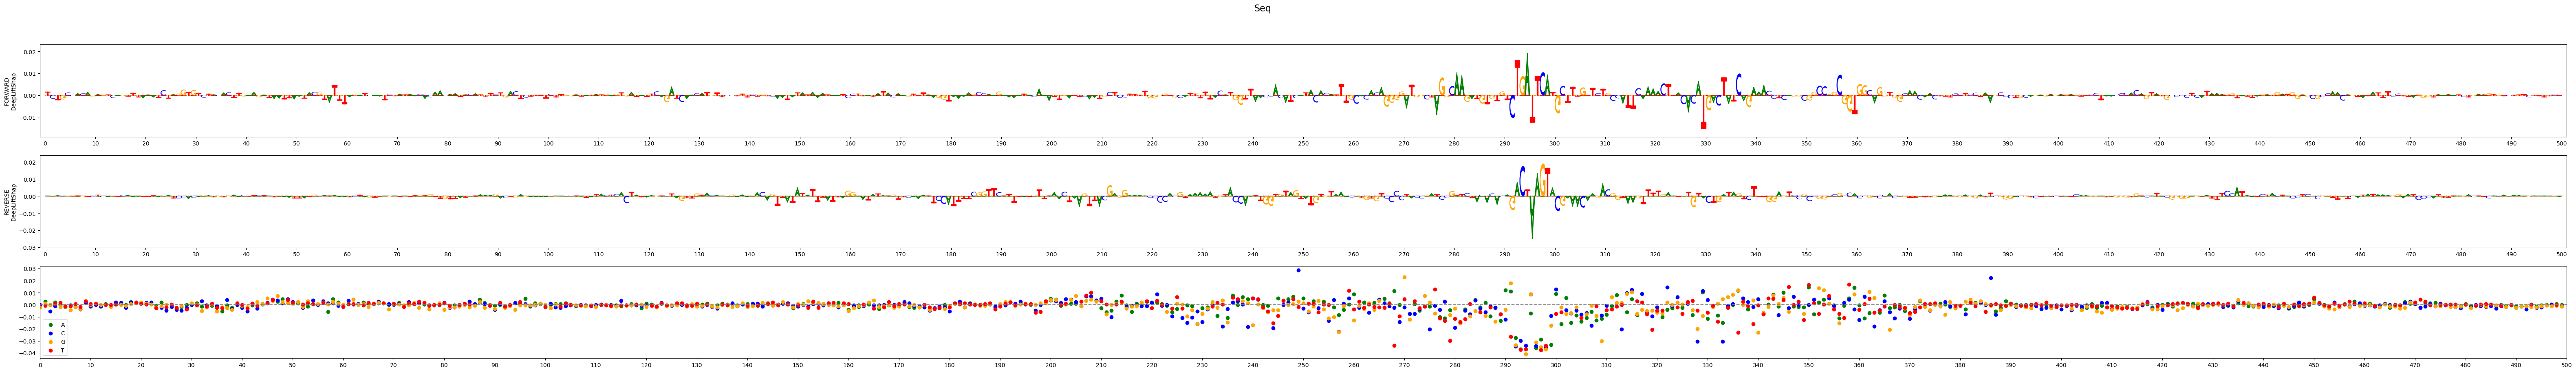

In [26]:
ntrack=3
fig = plt.figure(figsize=(80,10))
fig.suptitle(sequence_name,fontsize=16)
ax1 = plot_weights_modified(shap_values*input_tensor.cpu(),fig,ntrack,1,1,subticks_frequency=10,\
                            ylab="FORWARD\nDeepLiftShap")

#plot rc in reverse(just complementary sequence)
reversed_shap_rc = torch.flip(shap_values_rc*input_tensor_rc.cpu(),dims=(0,2))
ax2 = plot_weights_modified(reversed_shap_rc,fig,ntrack,1,2,subticks_frequency=10,\
                            ylab="REVERSE\nDeepLiftShap")


#mutagenesis
arrr_A = np.zeros((NUM_CLASSES,input_tensor.shape[2]))
arrr_C = np.zeros((NUM_CLASSES,input_tensor.shape[2]))
arrr_G = np.zeros((NUM_CLASSES,input_tensor.shape[2]))
arrr_T = np.zeros((NUM_CLASSES,input_tensor.shape[2]))

real_score=pred
new_X = torch.clone(input_tensor)

for mutloc in range(input_tensor.shape[2]):     
    new_X_= torch.clone(new_X)
    new_X_[0][:,mutloc] = torch.ByteTensor([1, 0, 0, 0])
    arrr_A[:,mutloc]=(real_score - model(new_X_)).detach().cpu().numpy()
    new_X_[0][:,mutloc] = torch.ByteTensor([0, 1, 0, 0])
    arrr_C[:,mutloc]=(real_score - model(new_X_)).detach().cpu().numpy()
    new_X_[0][:,mutloc] = torch.ByteTensor([0, 0, 1, 0])
    arrr_G[:,mutloc]=(real_score - model(new_X_)).detach().cpu().numpy()
    new_X_[0][:,mutloc] = torch.ByteTensor([0, 0, 0, 1])
    arrr_T[:,mutloc]=(real_score - model(new_X_)).detach().cpu().numpy()
arrr_A[arrr_A==0]=None
arrr_C[arrr_C==0]=None
arrr_G[arrr_G==0]=None
arrr_T[arrr_T==0]=None

ax = fig.add_subplot(ntrack,1,3)
ax.scatter(range(input_tensor.shape[2]),-1*arrr_A[target],label='A',color='green')
ax.scatter(range(input_tensor.shape[2]),-1*arrr_C[target],label='C',color='blue')
ax.scatter(range(input_tensor.shape[2]),-1*arrr_G[target],label='G',color='orange')
ax.scatter(range(input_tensor.shape[2]),-1*arrr_T[target],label='T',color='red')
ax.legend()
ax.axhline(y=0,linestyle='--',color='gray')
ax.set_xlim((0,input_tensor.shape[2])) 
ax.set_xticks(np.arange(0, input_tensor.shape[2]+1, 10))

fig.show()